## Analysis

You will need to install both `networkx` (using `pip`) and `matplotlib` (see <http://matplotlib.org/users/installing.html> for installation instructions)

In [76]:
clearStardog()

Transaction id: 80d8eaa9-b44f-472d-895e-3dee14713f67
Sent clear request: 200
Closing transaction: 200


In [1]:
import networkx as nx
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
import matplotlib.pyplot as plt
from rdflib import ConjunctiveGraph,Dataset, URIRef, Literal, Namespace, RDF, RDFS, OWL, XSD
from iribaker import to_iri
import random
%matplotlib inline  

In [2]:
prefix = "PREFIX : <http://localhost:5820/randomDataset/vocab/>"
TUTORIAL_REPOSITORY = "http://localhost:5820/randomDataset"
endpoint = TUTORIAL_REPOSITORY + "/query"

In [3]:
def clearStardog():
    """Careful! This one clears the entire stardog repository specified in TUTORIAL_REPOSITORY"""
    transaction_begin_url = TUTORIAL_REPOSITORY + "/transaction/begin"
    
    # Start the transaction, and get a transaction_id
    response = requests.post(transaction_begin_url, headers={'Accept': 'text/plain'})
    transaction_id = response.content

    print "Transaction id: {}".format(transaction_id)
    # POST the data to the transaction
    post_url = TUTORIAL_REPOSITORY + "/" + transaction_id + "/clear"
    response = requests.post(post_url, headers={'Accept': 'text/plain'})
    
    print "Sent clear request: {}".format(response.status_code)
    
    # Close the transaction
    transaction_close_url = TUTORIAL_REPOSITORY + "/transaction/commit/" + transaction_id
    response = requests.post(transaction_close_url)

    print "Closing transaction: {}".format(response.status_code)
    
    return

def upload_file_to_stardog(filename, mimetype='application/trig'):
    """Well, obvious what this does... you can set the 'mimetype' to e.g. text/turtle if you want to upload a turtle file"""
    with open(filename,'r') as f:
        data = f.read()
        
    upload_to_stardog(data, mimetype=mimetype)
    
    return

def upload_to_stardog(data, mimetype='application/trig'):
    """Upload data to Stardog, you know this one from the previous assignments..."""
    transaction_begin_url = TUTORIAL_REPOSITORY + "/transaction/begin"
    
    # Start the transaction, and get a transaction_id
    response = requests.post(transaction_begin_url, headers={'Accept': 'text/plain'})
    transaction_id = response.content

    print "Transaction id: {}".format(transaction_id)
    
    # POST the data to the transaction
    post_url = TUTORIAL_REPOSITORY + "/" + transaction_id + "/add"
    response = requests.post(post_url, data=data, headers={'Accept': 'text/plain', 'Content-type': mimetype}, stream=True)

    print "Sent add request: {}".format(response.status_code)
    
    # Close the transaction
    transaction_close_url = TUTORIAL_REPOSITORY + "/transaction/commit/" + transaction_id
    response = requests.post(transaction_close_url)

    print "Closing transaction: {}".format(response.status_code)
    
    return

def getClasses(reasoning='true', max=None):
    """Get all classes from the repo, optionally with a limit of `max`"""
    if max is None :
        query = prefix + """SELECT DISTINCT ?c WHERE {?c a owl:Class }"""
    else :
        query = prefix + """SELECT DISTINCT ?c WHERE {?c a owl:Class } LIMIT """ + str(max)
#     print query
    result = runQuery(query, reasoning)
#     print result
    return [r['c']['value'] for r in result]
    

def getInstances(className, reasoning='true', limit=None):
    """Get the instances for a class.. be sure to include < and > around its URI"""
    query = prefix + """
    SELECT ?i WHERE {{?i ?a ?b. ?i a {} ; }}
    """.format(className)
    if limit:
        query += " LIMIT "+str(limit)
    print query
    return [r['i']['value'] for r in runQuery(query, reasoning)]

def countUsage(reasoning='true', max=None):
    """Count the number of occurrences of a resource. Will differ significantly if reasoning is 'false'"""
    query = """
        SELECT ?resource (COUNT(?resource) as ?count) WHERE {
            { ?resource ?p1 ?o1 . }
            UNION
            { ?s1 ?resource ?o2 . }
            UNION
            { ?s2 ?p2 ?resource . }
        } GROUP BY ?resource ORDER BY DESC(?count)
    """
    
    results = runQuery(query, reasoning)
    
    index = {}
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
        
        if 'resource' in r:
            index[unicode(r['resource']['value'])] = int(r['count']['value'])
        
        count += 1
    
    return index


def countClassUsage(reasoning='true', max=None):
    """Count how many (inferred) instances a class has"""
    query = """
        SELECT ?class (COUNT(?resource) as ?count) WHERE {
            ?resource a ?class . 
        } GROUP BY ?class ORDER BY DESC(?count)
    """
    
    results = runQuery(query, reasoning)
    
    index = {}
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
        
        if 'class' in r:
            index[unicode(r['class']['value'])] = int(r['count']['value'])
        
        count += 1
    
    return index

def countUsageLocal(rdfgraph, max=None):
    """Count usage of a resource on a local RDFLib graph"""
    query = """
        SELECT ?resource (COUNT(?resource) as ?count) WHERE {
            { ?resource ?p1 ?o1 . }
            UNION
            { ?s1 ?resource ?o2 . }
            UNION
            { ?s2 ?p2 ?resource . }
        } GROUP BY ?resource ORDER BY ?resource
    """
    
    results = g.query(query)
    
    index = {}
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
            
        index[unicode(r['resource'])] = int(r['count'])
        
        count += 1
    
    return index
    

def runQuery(query, reasoning='true'):
    """Run a SPARQL query against the endpoint"""
    sparql = SPARQLWrapper(endpoint)

    sparql.setQuery(query)

    sparql.setReturnFormat(JSON)
    sparql.addParameter('Accept','application/sparql-results+json')

    sparql.addParameter('reasoning',reasoning)

    response = sparql.query().convert()

    return response['results']['bindings']

### Generate Dataset

In [4]:
def generate_vocab():
    fname = 'random_vocab.ttl'
    with open(fname, 'w') as f:
        prefixes = '''@prefix : <http://localhost:5820/randomDataset/vocab#> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix xml: <http://www.w3.org/XML/1998/namespace> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .\n\n'''
        meta_info = '''<http://localhost:5820/randomDataset/vocab> a owl:Ontology ;
\towl:versionInfo "Created by a python script"^^xsd:string ;
\t<http://purl.org/dc/elements/1.1/creator> "Ryan Amirkhan"^^xsd:string , "Erik van Egmond"^^xsd:string .\n\n'''
        
        f.write(prefixes)
        f.write(meta_info)
        
        class_counter = 0
        #genereate N top classes
        n = 3
        classes = []
        for i in range(n):
            class_name = "Class%d"%(class_counter)
            classes.append(class_name)
            class_trig = ""
            class_trig += ":%s\n"%(class_name)
            class_trig += "\trdf:type owl:Class ;\n"
            class_trig += "\trdfs:label \"%s\"^^xsd:string ;\n"%(class_name)
            class_trig += "\trdfs:subClassOf owl:Thing ;\n"
            class_trig += ".\n"
            class_counter += 1
            f.write(class_trig) 
        
        #generate m random subclasses
        m = 10
        for i in range(m):
            sub_class_of = random.choice(classes)
            class_name = "Class%d"%(class_counter)
            classes.append(class_name)
            class_trig = ""
            class_trig += ":%s\n"%(class_name)
            class_trig += "\trdf:type owl:Class ;\n"
            class_trig += "\trdfs:label \"%s\"^^xsd:string ;\n"%(class_name)
            class_trig += "\trdfs:subClassOf :%s ;\n"%(sub_class_of)
            class_trig += ".\n"
            class_counter += 1 
            f.write(class_trig) 
        return classes

In [34]:
# classes = generate_vocab()

In [13]:
# initialize our own ontology (classes and relations)
# 0 = Thing; 1 = Location; 2 = Event;
# 3 = Accident; 4 = TrafficAccident; 5 = Town;
# 6 = Junction; 7 = DangerousJunction; 8 = TrafficlightJunction
# 9 = RoadSection; 10 = DangerousRoadSection;
# 11 = Trafficlight; 12 = Street
initClasses = range(12)
# ignore owl:Thing relations [(1,0),(2,0)]
initRelations = [(3,2),(4,3),(5,1),(6,1),(7,6),(8,1),(8,6),(9,1),(10,9),(11,1),(12,1)]

In [5]:
def generate_graph(nodes=10, edges=20, initC=None, initR=None):
    '''Generate a random graph using networkx.
    Optionally use an existing graph as initial state; enriching the initial graph with new classes and relations.'''
    if initC and initR:
        G = nx.DiGraph(data=initR)
        newNodes = range(len(initC), len(initC) + nodes)
        G.add_nodes_from(newNodes)
        connectedNodes = [x for x in initC]
        countEdges = len(G.edges())
        # continue adding edges until the minimum number of edges has been reached
        # and all new nodes are somehow connected to the graph (ensures no disjoint graphs)
        while countEdges < edges or newNodes:
            if newNodes:
                n1 = random.choice(newNodes)
                del newNodes[newNodes.index(n1)]
                n2 = random.choice(connectedNodes)
                connectedNodes.append(n1)
            else:
                n1 = random.choice(G.nodes())
                n2 = random.choice(G.nodes())
            G.add_edge(n1, n2)
            countEdges += 1
    else:
        G = nx.gnm_random_graph(nodes, edges, directed=True)
    
    # visualize the graph
    edges = G.edges()
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'))
    nx.draw_networkx_edges(G, pos, edgelist=edges, arrows=True)
    plt.show()
    
    return G

def getSuperclasses(node, edges):
    return [x[1] for x in edges if x[0] == node]

def graph2rdf(graph, filename='graph2rdf_vocab'):
    fname = '%s.ttl'%(filename)
    with open(fname, 'w') as f:
        prefixes = '''@prefix : <http://localhost:5820/randomDataset/vocab#> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix xml: <http://www.w3.org/XML/1998/namespace> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .\n\n'''
        meta_info = '''<http://localhost:5820/randomDataset/vocab> a owl:Ontology ;
\towl:versionInfo "Created by a python script"^^xsd:string ;
\t<http://purl.org/dc/elements/1.1/creator> "Ryan Amirkhan"^^xsd:string , "Erik van Egmond"^^xsd:string .\n\n'''
        
        f.write(prefixes)
        f.write(meta_info)
        
        classes = graph.nodes()
        relations = graph.edges()
        
        for myClass in classes:
            class_name = "Class%s"%(myClass)
            class_trig = ""
            class_trig += ":%s\n"%(class_name)
            class_trig += "\trdf:type owl:Class ;\n"
            class_trig += "\trdfs:label \"%s\"^^xsd:string ;\n"%(class_name)
            class_trig += "\trdfs:subClassOf owl:Thing ;\n"
            for superclass in getSuperclasses(myClass, relations):
                superclassName = 'Class' + str(superclass)
                class_trig += "\trdfs:subClassOf :%s ;\n"%(superclassName)
            class_trig += ".\n"
            f.write(class_trig)
        
    print '### DONE Graph2RDF ###'

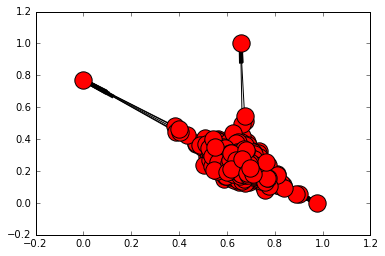

In [81]:
# myGraph = generate_graph(nodes=10, edges=20)
myGraph = generate_graph(nodes=1000, edges=3000, initC=initClasses, initR=initRelations)

In [82]:
# convert graph to rdf and write to file
graph2rdf(myGraph, 'test_graph')

### DONE Graph2RDF ###


In [83]:
# A namespace for our resources
data = 'http://localhost:5820/randomDataset/resource/'
DATA = Namespace(data)
# A namespace for our vocabulary items (schema information, RDFS, OWL classes and properties etc.)
vocab = 'http://localhost:5820/randomDataset/vocab/'
VOCAB = Namespace('http://localhost:5820/randomDataset/vocab/')

# The URI for our graph
graph_uri = URIRef('http://localhost:5820/randomDataset/resource/trafficlightgraph')

# We initialize a dataset, and bind our namespaces
dataset = Dataset()
dataset.bind('g12data',DATA)
dataset.bind('g12vocab',VOCAB)

# We then get a new graph object with our URI from the dataset.
graph = dataset.graph(graph_uri)

dataset.default_context.parse('test_graph.ttl', format='turtle')
upload_file_to_stardog('test_graph.ttl', mimetype='text/turtle')
# print dataset

Transaction id: 92693e11-10b7-4d10-ab1c-d3303cc41aaf
Sent add request: 200
Closing transaction: 200


In [84]:
def generate_instances(classes, n=1000):
    #generates n instances of classes
    resource_counter = 0
    for row in range(n):
        subclass = URIRef(random.choice(classes))
        instance_name = "resource%d"%(resource_counter)
        subject = URIRef(to_iri(data + 'resource/' + instance_name))
        graph.add((subject, RDF.type, subclass))
        graph.add((subject, RDFS.label, Literal(instance_name, datatype=XSD['string'])))
        
        resource_counter+=1
    upload_to_stardog(dataset.serialize(format='trig'))

In [85]:
classes = getClasses(reasoning='false')
print len(classes)
generate_instances(classes, 10000)

1012
Transaction id: 650a64d3-49d7-4bf4-8900-53a4769f2e58
Sent add request: 200
Closing transaction: 200


### Example analysis

Upload the example files to Stardog

Now get all classes from the repository. Select one, and use its URI to retrieve instances.

(Play around with reasoning 'false' and 'true')

In [5]:
classes = getClasses(reasoning='true')
for clazz in classes:
    print clazz
print len(classes)

http://localhost:5820/randomDataset/vocab#Class851
http://localhost:5820/randomDataset/vocab#Class852
http://localhost:5820/randomDataset/vocab#Class610
http://localhost:5820/randomDataset/vocab#Class850
http://localhost:5820/randomDataset/vocab#Class617
http://localhost:5820/randomDataset/vocab#Class859
http://localhost:5820/randomDataset/vocab#Class618
http://localhost:5820/randomDataset/vocab#Class615
http://localhost:5820/randomDataset/vocab#Class857
http://localhost:5820/randomDataset/vocab#Class858
http://localhost:5820/randomDataset/vocab#Class616
http://localhost:5820/randomDataset/vocab#Class855
http://localhost:5820/randomDataset/vocab#Class613
http://localhost:5820/randomDataset/vocab#Class614
http://localhost:5820/randomDataset/vocab#Class856
http://localhost:5820/randomDataset/vocab#Class611
http://localhost:5820/randomDataset/vocab#Class853
http://localhost:5820/randomDataset/vocab#Class612
http://localhost:5820/randomDataset/vocab#Class854
http://localhost:5820/randomDat

In [ ]:
# inst = getInstances('<http://www.w3.org/2002/07/owl#Thing>', reasoning='true', limit=1000)
inst = getInstances('<http://localhost:5820/randomDataset/vocab#Class3>', reasoning='true', limit=1000)

print len(inst)

PREFIX : <http://localhost:5820/randomDataset/vocab/>
    SELECT ?i WHERE {?i ?a ?b. ?i a <http://localhost:5820/randomDataset/vocab#Class3> ; }
     LIMIT 1000


### Locally

Load the example files in an RDFLib graph (locally). Note that a large graph may become problematic (given memory limitations).

A `ConjunctiveGraph` object allows for loading named graphs, but hides them (i.e. you don't need to think about the graphs when querying the data).

In [ ]:
g = ConjunctiveGraph()

g += g.parse('graph2rdf_vocab.ttl', format='turtle')


Several simple statistics. The following code uses the `index` variable. Adjust where needed (e.g. replace `index` with `index_remote`)

In [49]:
index = countUsageLocal(g)

In [50]:
index

{u'Class1': 1,
 u'Class10': 1,
 u'Class11': 1,
 u'Class12': 1,
 u'Class13': 1,
 u'Class14': 1,
 u'Class15': 1,
 u'Class16': 1,
 u'Class17': 1,
 u'Class18': 1,
 u'Class19': 1,
 u'Class2': 1,
 u'Class20': 1,
 u'Class21': 1,
 u'Class3': 1,
 u'Class4': 1,
 u'Class5': 1,
 u'Class6': 1,
 u'Class7': 1,
 u'Class8': 1,
 u'Class9': 1,
 u'Created by a python script': 1,
 u'Erik van Egmond': 1,
 u'Ryan Amirkhan': 1,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab': 4,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class1': 9,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class10': 7,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class11': 6,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class12': 5,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class13': 4,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class14': 7,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class15': 4,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class16': 4,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Clas

In [51]:
index_remote = countUsage(reasoning='false')

In [52]:
index_remote

{u'Class0': 1,
 u'Class1': 1,
 u'Class10': 1,
 u'Class11': 1,
 u'Class12': 1,
 u'Class13': 1,
 u'Class14': 1,
 u'Class15': 1,
 u'Class16': 1,
 u'Class17': 1,
 u'Class18': 1,
 u'Class19': 1,
 u'Class2': 1,
 u'Class20': 1,
 u'Class21': 1,
 u'Class3': 1,
 u'Class4': 1,
 u'Class5': 1,
 u'Class6': 1,
 u'Class7': 1,
 u'Class8': 1,
 u'Class9': 1,
 u'Created by a python script': 1,
 u'Erik van Egmond': 1,
 u'Ryan Amirkhan': 1,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab': 4,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class0': 5,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class1': 9,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class10': 7,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class11': 7,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class12': 5,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class13': 4,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class14': 7,
 u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class15': 4,
 u'http://data.krw.d2s.labs.vu.nl/grou

In [19]:
index_classes = countClassUsage(reasoning='true')

ValueError: No JSON object could be decoded

In [54]:
index_classes

{}

Get the frequencies for each resource, and sort by frequency value.

Plot them at loglog scale

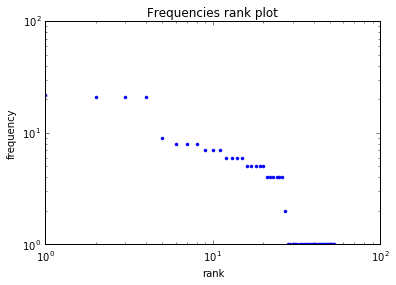

In [55]:
frequencies_by_value = sorted(index.values(), reverse=True)

plt.loglog(frequencies_by_value,'b-',linestyle='None', marker='.')
plt.title("Frequencies rank plot")
plt.ylabel("frequency")
plt.xlabel("rank")

Get the frequencies for each resource, and sort by URI name (i.e. alphabetically)

Plot them at loglog scale

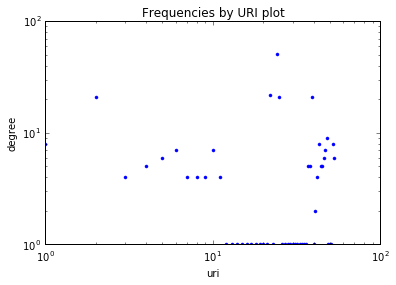

In [56]:
frequencies_by_URI = index.values()

plt.loglog(frequencies_by_URI,'b-',linestyle='None', marker='.')
plt.title("Frequencies by URI plot")
plt.ylabel("degree")
plt.xlabel("uri")

### Network Analysis

Build a directed `networkx` graph from the RDF graph

In [57]:
def buildNetwork(rdfgraph, query = """SELECT * WHERE {?source ?edge ?target.}""", max=None):
    ## Query is assumed to have a source, target and edge
    
    results = g.query(query)
    
    G = nx.DiGraph()
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
        
        G.add_edge(r['source'], r['target'], {'type': r['edge']})
        
        count += 1
        
    return G


In [58]:
G = buildNetwork(g, max=10000)

Get the degrees for each node in the graph, and sort them from large to small

In [59]:
degree_sequence=sorted(nx.degree(G).values(),reverse=True) # degree sequence

# And see what it looks like...
degree_sequence

[21,
 21,
 9,
 8,
 8,
 8,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

Plot the graph using a spring layout (warning, may be very slow for large graphs)

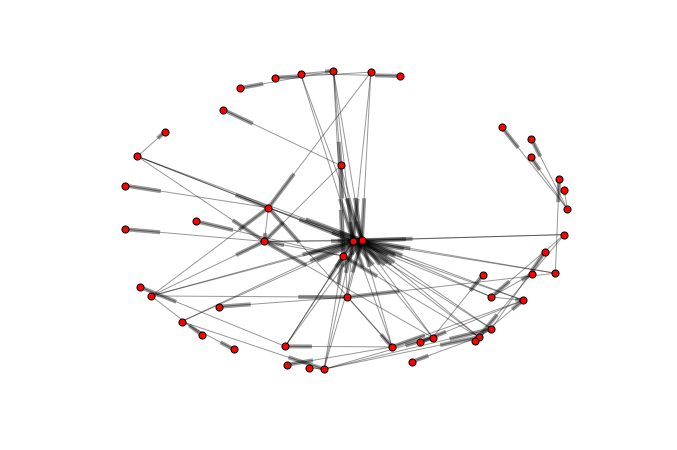

In [60]:
# draw graph in inset
plt.axes([1.45,1.45,1.45,1.45])
#Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)[0]
pos=nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G,pos,node_size=50)
nx.draw_networkx_edges(G,pos,alpha=0.4)

# plt.savefig("graph.png")
plt.show()

Plot the degrees at loglog scale

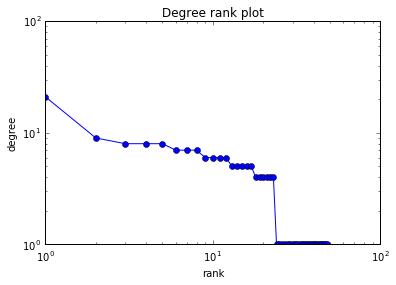

In [61]:
degree_sequence=sorted(nx.degree(G).values(),reverse=True) # degree sequence
#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

You can also do Pagerank on the graph (have a look at the `networkx` documentation)

In [62]:
nx.pagerank(G)

{rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group12/vocab'): 0.013625026400735629,
 rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class1'): 0.03590662796985973,
 rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class10'): 0.018952662814533037,
 rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class11'): 0.019570015876026144,
 rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class12'): 0.013625026400735629,
 rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class13'): 0.013625026400735629,
 rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class14'): 0.018450562749960528,
 rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class15'): 0.013625026400735629,
 rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class16'): 0.013625026400735629,
 rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group12/vocab#Class17'): 0.013625026400735629,
 rdflib.te